In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
drive_zip_path = '/content/drive/MyDrive/Dataset/Brain Tumor MRI images.zip'

print("Copying data from Google Drive to local Colab runtime...")
start_time = time.time()
!cp '{drive_zip_path}' '/content/dataset.zip'

end_time = time.time()
print(f"Copying took {end_time - start_time:.2f} seconds.")

print("\nUnzipping data...")
!unzip -q /content/dataset.zip -d /content/dataset

print("Data is ready for local processing!")

Copying data from Google Drive to local Colab runtime...
Copying took 0.40 seconds.

Unzipping data...
Data is ready for local processing!


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
data_dir='/content/drive/MyDrive/Dataset/Brain Tumor MRI images'
categories=['Tumor','Healthy']
img_size=150

In [5]:
def create_training_data():
  training_data=[]
  for cat in categories:
    path=os.path.join(data_dir,cat)
    class_num=categories.index(cat)
    for img_name in os.listdir(path):
      try:
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data
training_data = create_training_data()
print(f"Data loading complete! Found {len(training_data)} images.")


import random
random.shuffle(training_data)

X = [] # Features (images)
y = [] # Labels (tumor/healthy)

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Data loading complete! Found 5093 images.
Training data shape: (4074, 150, 150, 3)
Testing data shape: (1019, 150, 150, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

model.save('brain_tumor_vgg16.h5')
print("Model saved as brain_tumor_vgg16.h5")

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9899 - loss: 0.0257 - val_accuracy: 0.9853 - val_loss: 0.0619
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.9872 - val_loss: 0.0587
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9946 - loss: 0.0175 - val_accuracy: 0.9902 - val_loss: 0.0563
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9948 - loss: 0.0156 - val_accuracy: 0.9921 - val_loss: 0.0519
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.9877 - loss: 0.0344 - val_accuracy: 0.9882 - val_loss: 0.0586
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.9843 - val_loss: 0.0593
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9937 - loss: 0.0160 - val_accuracy: 0.9872 - val_loss: 0.0594
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9941 - loss: 0

Model saved as brain_tumor_vgg16.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
Classification Report:

              precision    recall  f1-score   support

       Tumor       0.98      1.00      0.99       615
     Healthy       0.99      0.97      0.98       404

    accuracy                           0.99      1019
   macro avg       0.99      0.98      0.98      1019
weighted avg       0.99      0.99      0.99      1019


Confusion Matrix:



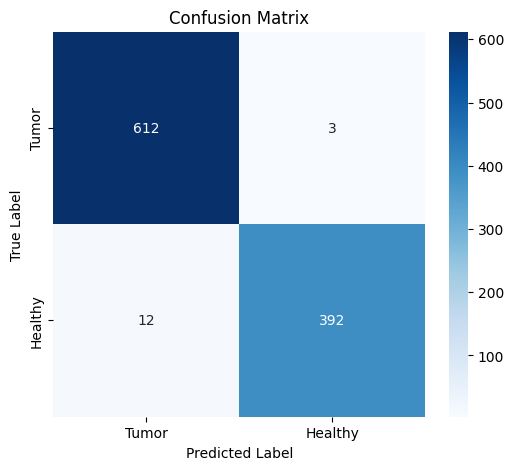

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_prob = model.predict(X_test)

y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=['Tumor', 'Healthy']))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tumor', 'Healthy'], yticklabels=['Tumor', 'Healthy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

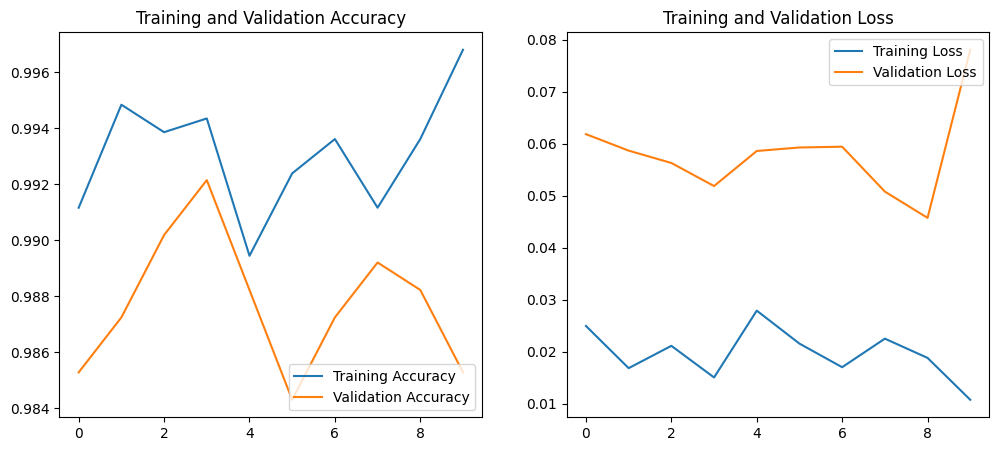

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()